# Dataset Generation

In [1]:
import numpy as np

np.random.seed(0) # to keep it reproducible
mean_slope = 2 # the 8 different slopes have a mean of 2
slopes = np.random.normal(mean_slope, size=8)
groups = np.array(50*[0, 1, 2, 3, 4, 5, 6] + 5*[7])
x = np.random.randn(355)
y = slopes[groups] * x + 0.1*np.random.randn(355)

In [14]:
# Addition of outliers

y[-1] = 30 # the last 5 observations are from minority group 7
y[-2] = 30

# Modelling

In [16]:
import pymc as pm
import arviz as az

### Pooled Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


<AxesSubplot: title={'center': 'slope'}>

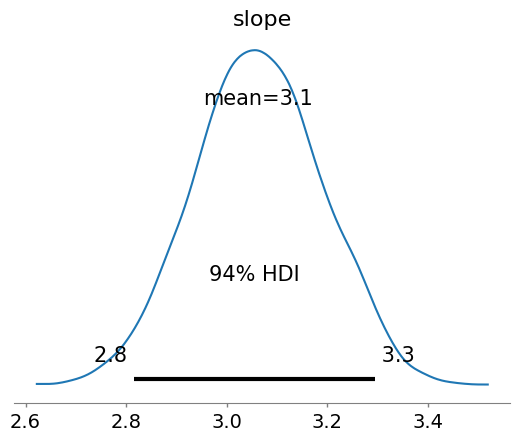

In [17]:
with pm.Model() as pooled_model:
    slope = pm.Normal('slope', 0, 20)
    noise = pm.Exponential('noise', 0.1)
    
    obs = pm.Normal('obs', slope*x, noise, observed=y)
    
    pooled_trace = pm.sample(return_inferencedata=True)
az.plot_posterior(pooled_trace, var_names=['slope'])

### Unpooled Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


array([[<AxesSubplot: title={'center': 'slope\n0'}>,
        <AxesSubplot: title={'center': 'slope\n1'}>,
        <AxesSubplot: title={'center': 'slope\n2'}>,
        <AxesSubplot: title={'center': 'slope\n3'}>],
       [<AxesSubplot: title={'center': 'slope\n4'}>,
        <AxesSubplot: title={'center': 'slope\n5'}>,
        <AxesSubplot: title={'center': 'slope\n6'}>,
        <AxesSubplot: title={'center': 'slope\n7'}>]], dtype=object)

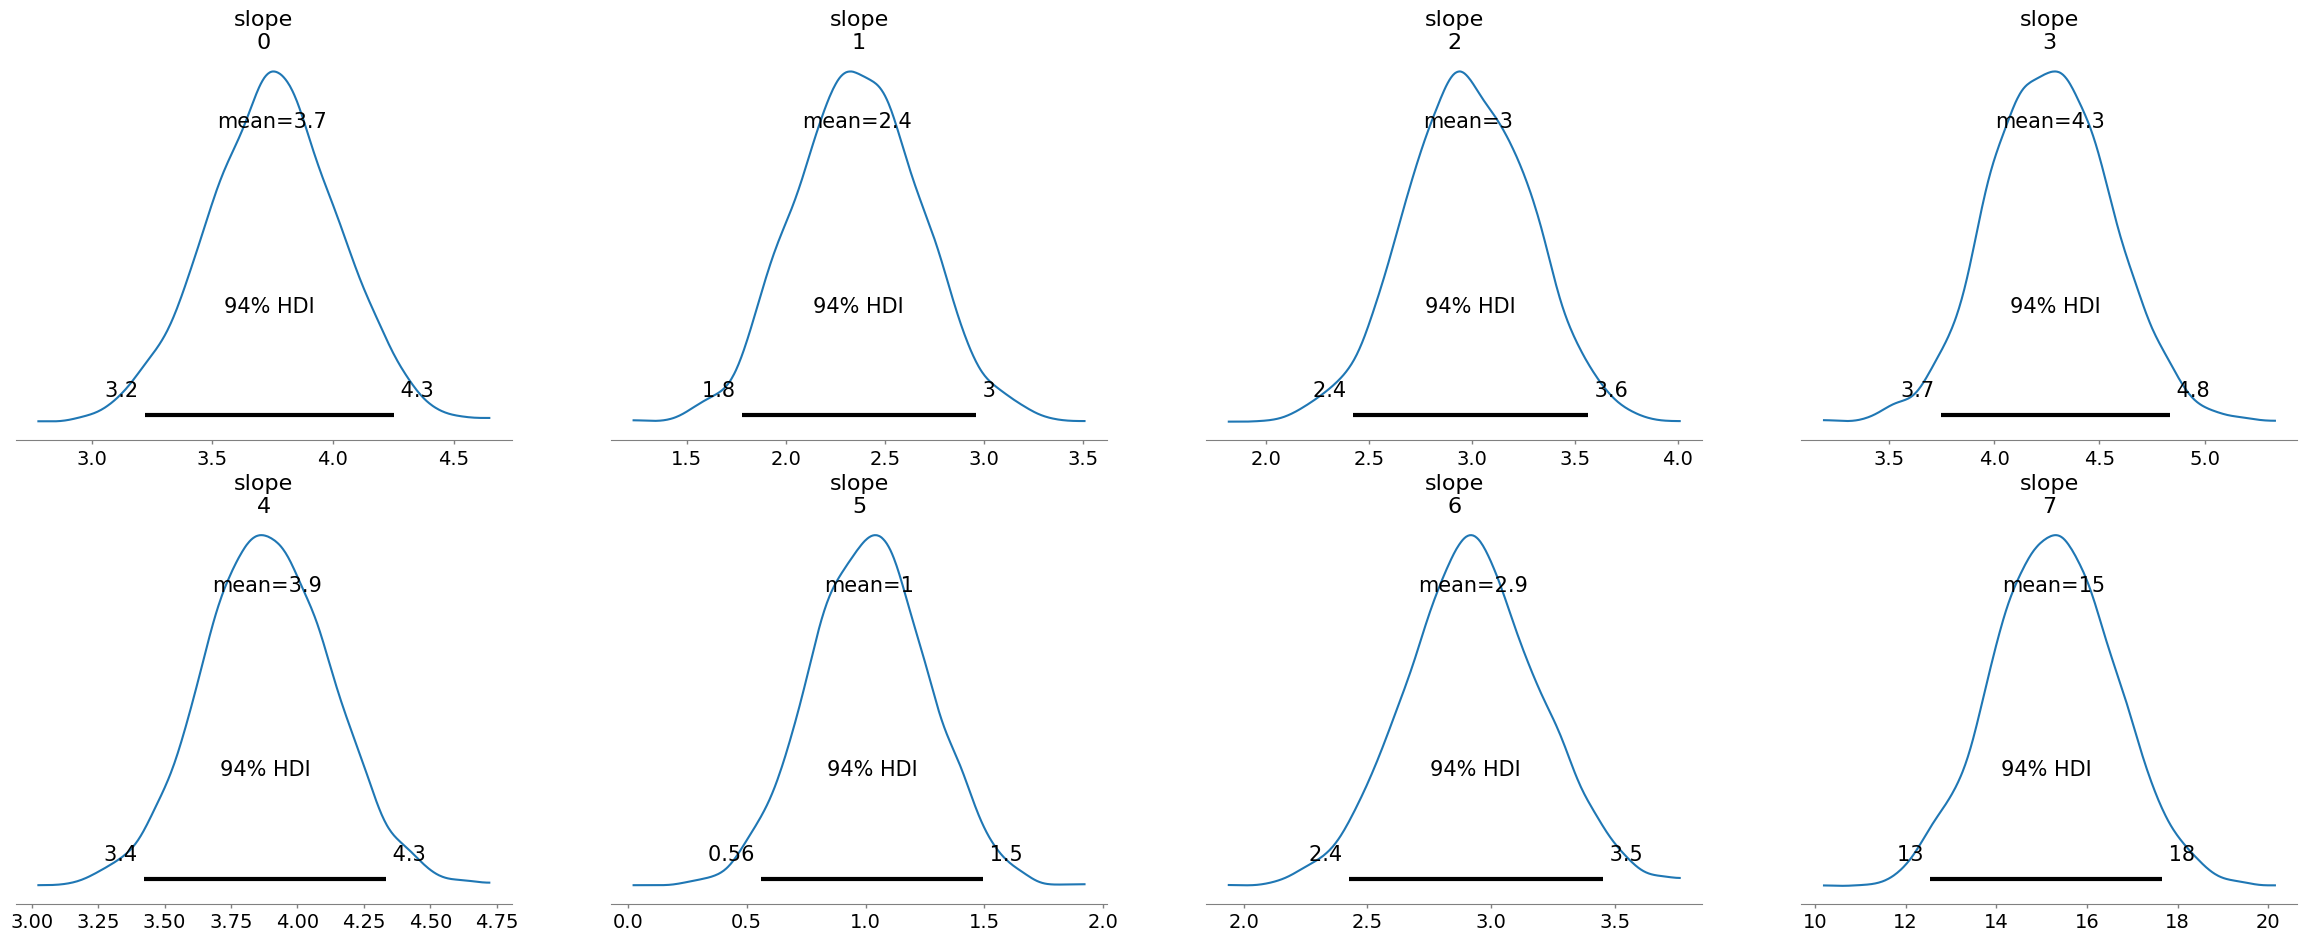

In [18]:
with pm.Model() as unpooled_model:
    slope = pm.Normal('slope', 0, 20, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x, noise, observed=y)
    
    unpooled_trace = pm.sample(return_inferencedata=True)
az.plot_posterior(unpooled_trace, var_names=['slope'])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

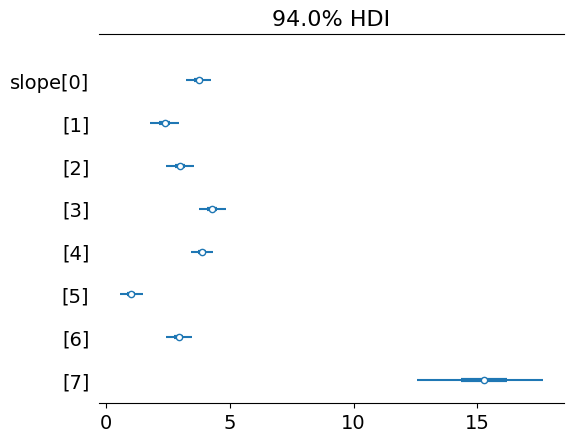

In [19]:
az.plot_forest(unpooled_trace, var_names=['slope'], combined=True)

### Partially Pooled aka Hierarchical Model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_slope, sigma_slope, slope, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


array([[<AxesSubplot: title={'center': 'mu_slope'}>,
        <AxesSubplot: title={'center': 'slope\n0'}>,
        <AxesSubplot: title={'center': 'slope\n1'}>],
       [<AxesSubplot: title={'center': 'slope\n2'}>,
        <AxesSubplot: title={'center': 'slope\n3'}>,
        <AxesSubplot: title={'center': 'slope\n4'}>],
       [<AxesSubplot: title={'center': 'slope\n5'}>,
        <AxesSubplot: title={'center': 'slope\n6'}>,
        <AxesSubplot: title={'center': 'slope\n7'}>],
       [<AxesSubplot: title={'center': 'sigma_slope'}>,
        <AxesSubplot: title={'center': 'noise'}>, <AxesSubplot: >]],
      dtype=object)

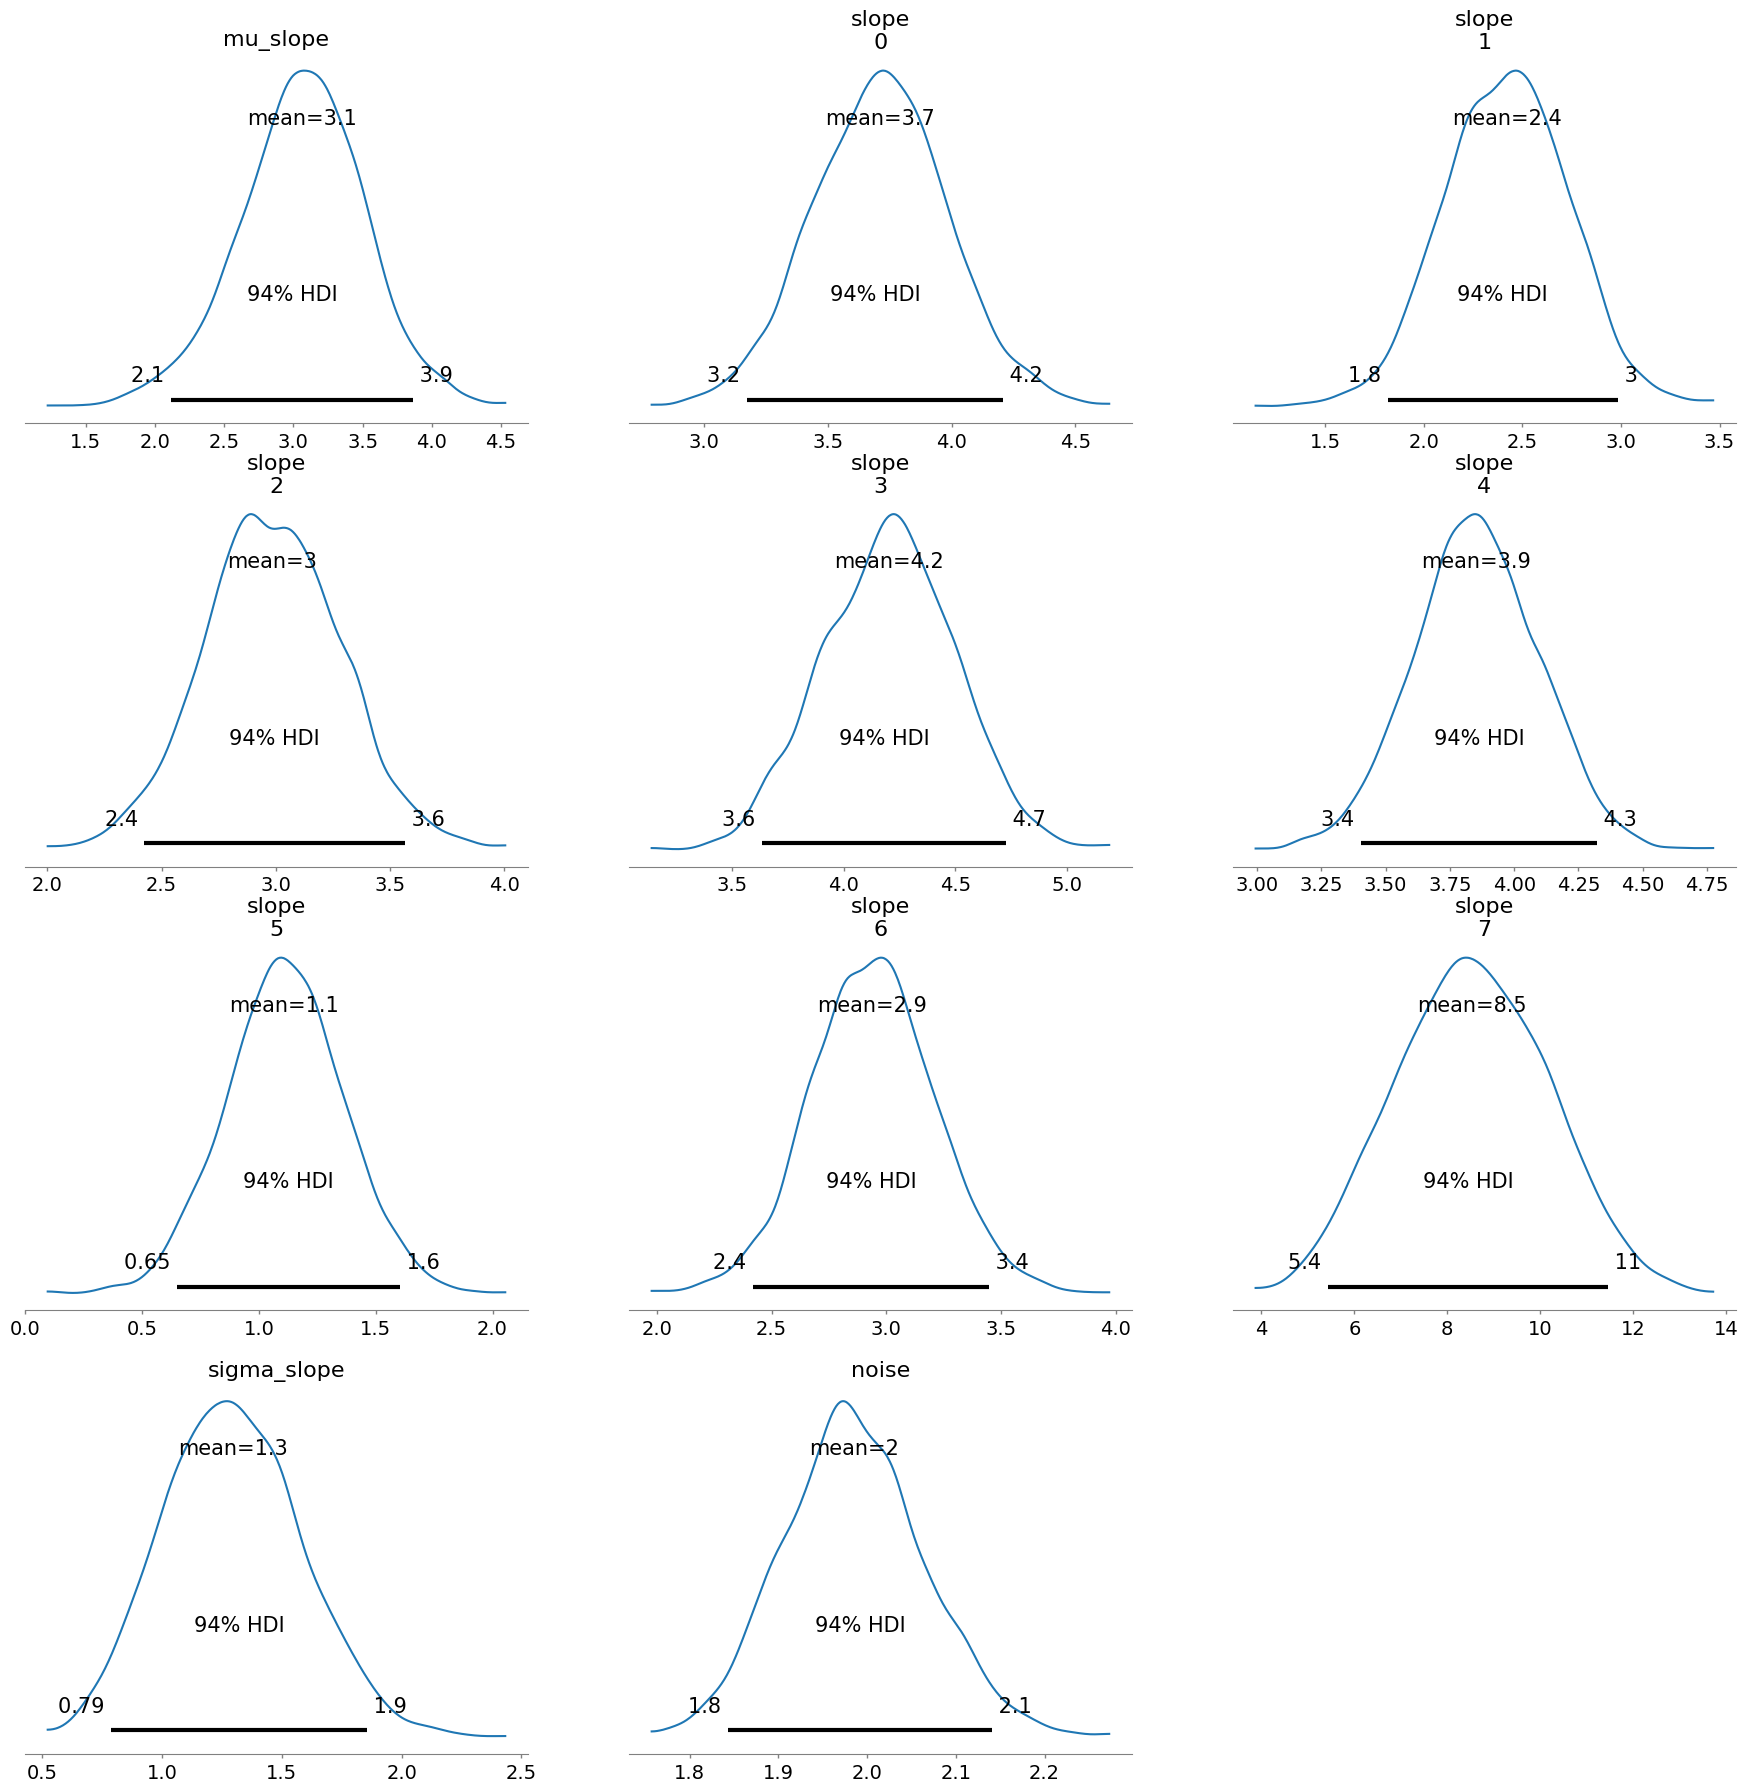

In [20]:
with pm.Model() as hierarchical_model:
    mu_slope = pm.Normal('mu_slope', 0, 1) # hyperprior 1
    sigma_slope = pm.Exponential('sigma_slope', 13) # hyperprior 2
    
    slope = pm.Normal('slope', mu_slope, sigma_slope, shape=8)
    noise = pm.Exponential('noise', 10)
    
    obs = pm.Normal('obs', slope[groups]*x, noise, observed=y)
    
    hierarchical_trace = pm.sample(
        return_inferencedata=True,
        target_accept=0.995
    )
az.plot_posterior(hierarchical_trace)

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

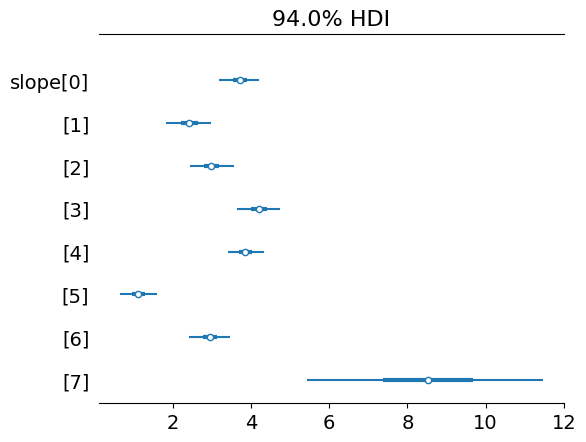

In [22]:
az.plot_forest(hierarchical_trace, var_names=['slope'], combined=True)

#### In hierarchical modeling, all parameters are being pulled towards a global mean. This effect is known as shrinkage.